Download Image Dataset if not downloaded

In [1]:
import os
import zipfile
import requests
from tqdm import tqdm

def download_file(url, save_path):
    """Downloads a file only if it does not already exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(save_path, "wb") as f, tqdm(
            desc=os.path.basename(save_path), total=total_size, unit='B', unit_scale=True
        ) as pbar:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    else:
        print(f"{os.path.basename(save_path)} already exists. Skipping download.")

def extract_zip(zip_path, extract_to):
    """Extracts a ZIP file only if the extracted directory does not already exist."""
    extracted_dir = os.path.join(extract_to, os.path.splitext(os.path.basename(zip_path))[0])
    if not os.path.exists(extracted_dir):
        print(f"Extracting {os.path.basename(zip_path)}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
    else:
        print(f"{os.path.basename(zip_path)} already extracted. Skipping extraction.")

# Dataset URLs
image_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
caption_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Create dataset directory
os.makedirs("flickr8k", exist_ok=True)

# Define file paths
image_zip_path = "flickr8k/Flickr8k_Dataset.zip"
caption_zip_path = "flickr8k/Flickr8k_text.zip"

# Download and extract images
download_file(image_url, image_zip_path)
extract_zip(image_zip_path, "flickr8k")

# Download and extract captions
download_file(caption_url, caption_zip_path)
extract_zip(caption_zip_path, "flickr8k")


Flickr8k_Dataset.zip already exists. Skipping download.
Extracting Flickr8k_Dataset.zip...
Flickr8k_text.zip already exists. Skipping download.
Extracting Flickr8k_text.zip...


Importing Embedding models to generate image and text embeddings

In [2]:
import numpy as np
import chromadb
from PIL import Image
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel


d:\work_station\mindflix\backend\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load CLIP Model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load Sentence Transformer for text embedding
text_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize ChromaDB for storing embeddings
chroma_client = chromadb.PersistentClient(path="./chroma_db")
collection = chroma_client.get_or_create_collection(name="image_search")


Storing the Embeddings in Vector Database (ChromaDB)

In [ ]:
import pandas as pd

# Load captions
caption_file = "flickr8k/Flickr8k.token.txt"
caption_data = pd.read_csv(caption_file, delimiter="\t", header=None, names=["file_name","image_caption"])

# Create dictionary: {image_name: caption}
image_captions = {}
for row in caption_data.itertuples():
    image_name= row.file_name.split("#")[0]
    caption = row.image_caption
    image_name = image_name.split("#")[0]  # Remove caption number (e.g., image1#0.jpg)

    if image_name not in image_captions:
        image_captions[image_name] = caption

In [6]:
def get_clip_embedding(image: Image.Image):
    """Generate CLIP image embedding"""
    inputs = clip_processor(images=image, return_tensors="pt")
    image_features = clip_model.get_image_features(**inputs)
    return image_features.detach().numpy().flatten()

def get_text_embedding(text: str):
    """Generate text embedding (512D)"""
    return text_model.encode(text)


In [ ]:
import glob
from tqdm import tqdm

# Get all image paths
image_dir = "flickr8k/Flicker8k_Dataset/"
image_paths = glob.glob(image_dir + "*.jpg")

def add_image_to_db(image_path):
    image_name = os.path.basename(image_path)
    if image_name not in image_captions:
        return

    existing_entry = collection.get(ids=[image_name])
    if len(existing_entry["ids"]) > 0:
        return

    caption = image_captions[image_name]
    image = Image.open(image_path).convert("RGB")
    image_embedding = get_clip_embedding(image)

    text_embedding = get_text_embedding(caption)

    image_embedding /= np.linalg.norm(image_embedding)
    text_embedding /= np.linalg.norm(text_embedding)

    combined_embedding = np.concatenate((image_embedding, text_embedding))
    # Store in ChromaDB
    collection.add(
        ids=[image_name],  # Store image_name as ID
        embeddings=[combined_embedding.tolist()],
        metadatas=[{"caption": caption, "image_path": image_path}],
    )


print("📥 Adding Images to Database...")
for img_path in tqdm(image_paths[:500], desc="Processing Images", unit="image"):
    add_image_to_db(img_path)

📥 Adding Images to Database...


Searching in vector Database using similarity search

In [10]:
def retrieve_similar_images(query_embedding, top_k=5):
    results = collection.query(query_embeddings=[query_embedding.tolist()],n_results=top_k)
    retrieved_images = []
    for i in range(len(results["ids"][0])):
        image_id = results["ids"][0][i]
        metadata = results["metadatas"][0][i]
        retrieved_images.append(metadata)

    return retrieved_images


In [19]:
def search( image=None, query_text=None):
    image_embedding = get_clip_embedding(image) if image else np.zeros(512)
    text_embedding = get_text_embedding(query_text) if query_text else np.zeros(384)
    
    image_embedding /= np.linalg.norm(image_embedding) if np.linalg.norm(image_embedding) != 0 else 1
    text_embedding /= np.linalg.norm(text_embedding) if np.linalg.norm(text_embedding) != 0 else 1
    
    combined_embedding = np.concatenate((image_embedding, text_embedding))
    return retrieve_similar_images(combined_embedding)

Testing of model using sample image and text

In [16]:
import matplotlib.pyplot as plt
import textwrap
from PIL import Image

BASE_DIR = "flickr8k/Flicker8k_Dataset/"
# Function to display results in a single-row format with captions below images
def display_results(title, results):
    num_results = min(len(results), 5)  # Limit to top 5 results

    if num_results == 0:
        print(f"\n No results found for {title}!\n")
        return

    fig, axes = plt.subplots(1, num_results, figsize=(15, 3))  # Single row layout
    fig.suptitle(title, fontsize=14, fontweight="bold")

    # If only one image, axes is not an array, so wrap it in a list
    if num_results == 1:
        axes = [axes]

    for i, res in enumerate(results[:5]):  # Show max 5 images
        img_path = BASE_DIR+res["image_path"]
        caption = res["caption"]

        axes[i].imshow(Image.open(img_path))
        axes[i].axis("off")

        # Wrap text caption to fit below the image
        wrapped_caption = "\n".join(textwrap.wrap(caption, width=30))
        axes[i].set_title(wrapped_caption, fontsize=10, pad=5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title properly
    plt.show()




📌 **Query Image:**


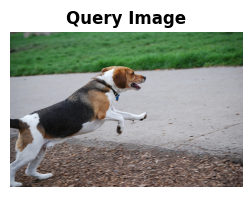

🔍 **Query Text:** A white dog jumping



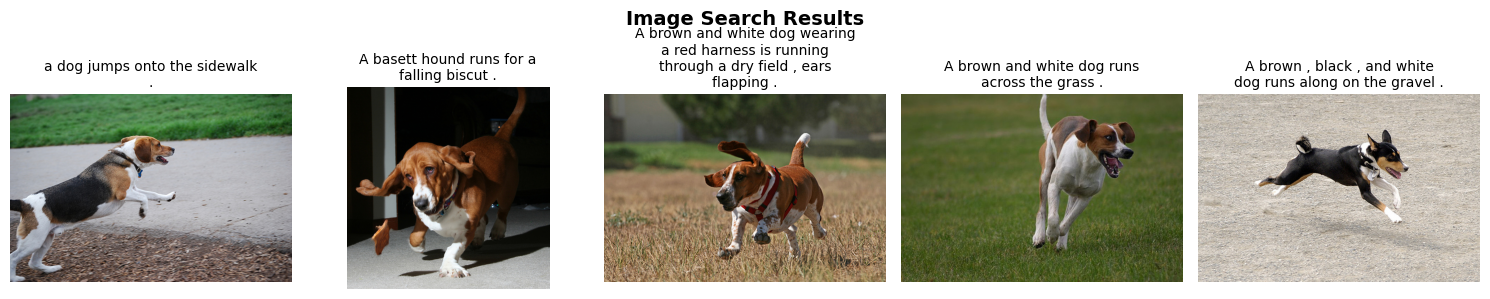

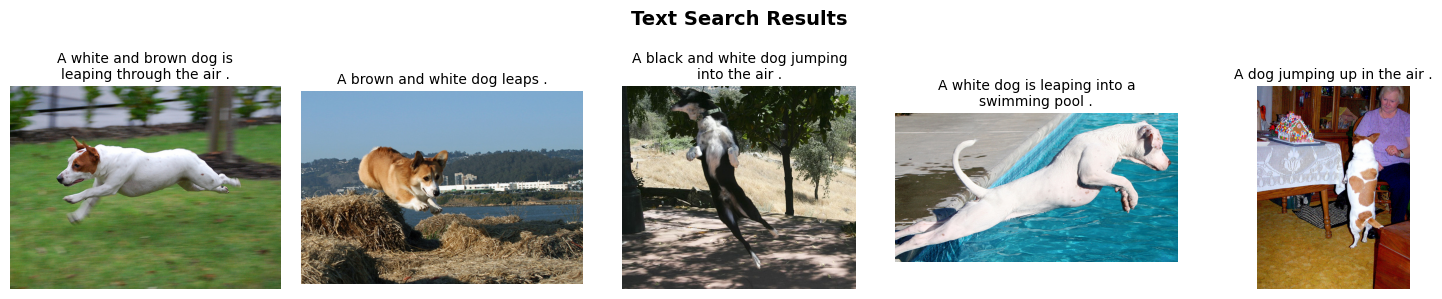

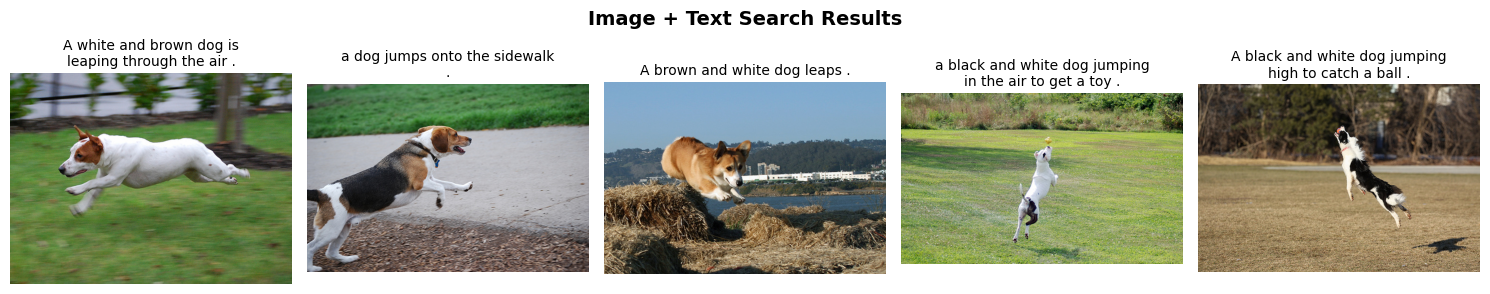

In [20]:
# Pick an image from the dataset for testing
test_image_path = image_paths[1001]  # Change index as needed
image=Image.open(test_image_path)
test_query_text = "A white dog jumping"

# Display the test query image
print("📌 **Query Image:**")
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis("off")
plt.title("Query Image", fontsize=12, fontweight="bold")
plt.show()

print(f"🔍 **Query Text:** {test_query_text}\n")


# Query 1: Image Search
img_results = search(image=image)
display_results("Image Search Results", img_results)
print()


# Query 2: Text Search
text_results = search(query_text=test_query_text)
display_results("Text Search Results", text_results)
print()


# Query 3: Image + Text Search
whole_results = search(image, test_query_text)
display_results("Image + Text Search Results", whole_results)
